# Biocatalysis Model Retraining

In [1]:
import re
from typing import List
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

### Helper Functions

In [2]:
def get_ec(ec_smiles: str) -> List[str]:
    ec = ec_smiles
    pre_ec_prod = ec_smiles.replace(">>", " ").replace("|", " ").split()

    if ">>" in ec_smiles and "|" in ec_smiles and len(pre_ec_prod) == 3:
        ec = pre_ec_prod[1]
    elif ">>" in ec_smiles:
        ec = "None.None.None"

    return list(ec.split("."))

def load_data(folder: str, set_name: str) -> pd.DataFrame:
    data = { 
        "EC1_GT": [], "EC2_GT": [], "EC3_GT": [], "EC1_PRED": [], 
        "EC2_PRED": [], "EC3_PRED": [], "GROUND_TRUTH": [], "PREDICTION": [], 
        "CORRECT": [], "MODEL": [], "K": [], "SET_NAME": []
    }

    for correct in [True, False]:
        for model in ["bw", "fw", "rtrp"]:
            for k in range(1, 6):
                correct_file_name = "correct" if correct else "incorrect"
                file = Path(folder, f"{correct_file_name}_{model}_{k}.txt")
                    
                with open(file, "r") as f:
                    for line in f:
                        rxn_gt = rxn_pred = ""
                        ec_gt = ec_pred = []

                        if correct:
                            rxn_gt = rxn_pred = line.strip()
                            ec_gt = ec_pred = get_ec(rxn_gt)
                        else:
                            rxn_gt, rxn_pred = line.strip().split(",")
                            ec_gt = get_ec(rxn_gt)
                            ec_pred = get_ec(rxn_pred)
                        
                        data["EC1_GT"].append(ec_gt[0])
                        data["EC2_GT"].append(ec_gt[1])
                        data["EC3_GT"].append(ec_gt[2])
                        data["EC1_PRED"].append(ec_pred[0])
                        data["EC2_PRED"].append(ec_pred[1])
                        data["EC3_PRED"].append(ec_pred[2])
                        data["GROUND_TRUTH"].append(rxn_gt)
                        data["PREDICTION"].append(rxn_pred)
                        data["CORRECT"].append(correct)
                        data["MODEL"].append(model)
                        data["K"].append(k)
                        data["SET_NAME"].append(set_name)
    
    return pd.DataFrame(data)

def load_data_train(src: str, tgt: str, set_name: str) -> pd.DataFrame:
    srcs = [re.sub(r"[vut\[\]]", "", line.strip().replace(" ", "").replace("][", ".")) for line in open(src, "r")]
    tgts = [line.strip().replace(" ", "") for line in open(tgt, "r")]
    data = {"GROUND_TRUTH": [], "EC1_GT": [], "EC2_GT": [], "EC3_GT": [], "SET_NAME": []}

    for s, t in zip(srcs, tgts):
        rxn = f"{s}>>{t}"
        data["GROUND_TRUTH"].append(rxn)
        ec = get_ec(rxn)
        data["EC1_GT"].append(ec[0])
        data["EC2_GT"].append(ec[1])
        data["EC3_GT"].append(ec[2])
        data["SET_NAME"].append(set_name)

    return pd.DataFrame(data)

### Load the Data using the Helper Functions

In [3]:
df_original = load_data("original", "original")
df_retrained = load_data("retrained/300000", "retrained")
df = pd.concat([df_original, df_retrained])

df_t_original = load_data_train("original/src-train.txt", "original/tgt-train.txt", "original")
df_t_retrained = load_data_train("retrained/src-train.txt", "retrained/tgt-train.txt", "retrained")
df_training = pd.concat([df_t_original, df_t_retrained])

# Remove class 7 as there are only very few examples
df = df[df["EC1_GT"] != "7"]
df_training = df_training[df_training["EC1_GT"] != "7"]

## Process Data

### Training Data

In [37]:
df_t_size = df_training.groupby(
    by=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME"]
).size().reset_index().rename(columns={0: "TRAINING_SAMPLE_COUNT"})

df_t_pivot = df_t_size.pivot(index=["EC1_GT", "EC2_GT", "EC3_GT"], columns="SET_NAME").reset_index()
df_t_pivot = df_t_pivot.fillna(0)
df_t_pivot.columns = df_t_pivot.columns.droplevel()
df_t_pivot = df_t_pivot.reset_index()
df_t_pivot.columns = [1, "EC1_GT", "EC2_GT", "EC3_GT", "ORIGINAL", "RETRAINED"]

df_t_pivot = df_t_pivot.sort_values(by="EC1_GT")
df_t_pivot["CHANGE"] = df_t_pivot["RETRAINED"] / df_t_pivot["ORIGINAL"] - 1

df_t_diversity = df_training.drop(columns=["GROUND_TRUTH"]).value_counts().reset_index().rename(columns={0: "COUNT"})
df_t_diversity = df_t_diversity.groupby(by=["EC1_GT", "SET_NAME"]).count().reset_index()

### Prediction Data

In [76]:
df_size = df.groupby(
    by=["EC1_GT", "EC2_GT", "EC3_GT", "MODEL", "K", "CORRECT", "SET_NAME"]
).size().reset_index().rename(columns={0: "COUNT"})


df_pivot = df_size.pivot(index=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME", "K", "MODEL"], columns="CORRECT").reset_index()
df_pivot = df_pivot.fillna(0)
df_pivot.columns = df_pivot.columns.droplevel()
df_pivot = df_pivot.reset_index()
df_pivot.columns = [1, "EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME", "K", "MODEL", "N_INCORRECT", "N_CORRECT"]
df_pivot["N_TOTAL"] = df_pivot["N_INCORRECT"] + df_pivot["N_CORRECT"]
df_pivot["ACCURACY"] = df_pivot["N_CORRECT"] / df_pivot["N_TOTAL"]
df_pivot["EC2"] = df_pivot["EC1_GT"] + "." + df_pivot["EC2_GT"]

### Combined Training and Prediction Data

In [131]:
df_joined_size = pd.merge(df_pivot, df_t_size, on=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME"], how="left")
df_joined_size = df_joined_size.pivot(
    index=["EC1_GT", "EC2_GT", "EC3_GT", "K", "MODEL"], 
    columns="SET_NAME", values=["ACCURACY", "TRAINING_SAMPLE_COUNT"]
).reset_index()
df_joined_size.columns = df_joined_size.columns.to_series().str.join("_").str.upper().str.strip("_")

df_joined_size["TRAINING_SAMPLE_COUNT_DIFF"] = df_joined_size["TRAINING_SAMPLE_COUNT_RETRAINED"] - df_joined_size["TRAINING_SAMPLE_COUNT_ORIGINAL"]
df_joined_size["ACCURACY_DIFF"] = df_joined_size["ACCURACY_RETRAINED"] - df_joined_size["ACCURACY_ORIGINAL"]

## Visualisations

### Training Data Comparison

<AxesSubplot:xlabel='EC1_GT', ylabel='CHANGE'>

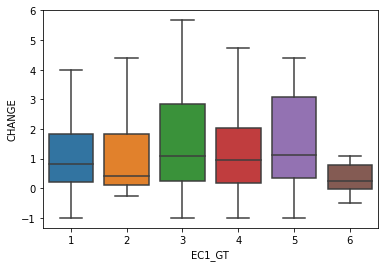

In [88]:
fig, ax = plt.subplots(1, 1)

sns.boxplot(
    data=df_t_pivot, 
    x="EC1_GT", y="CHANGE",
    showfliers=False,
    ax = ax
)

### Performance Comparison

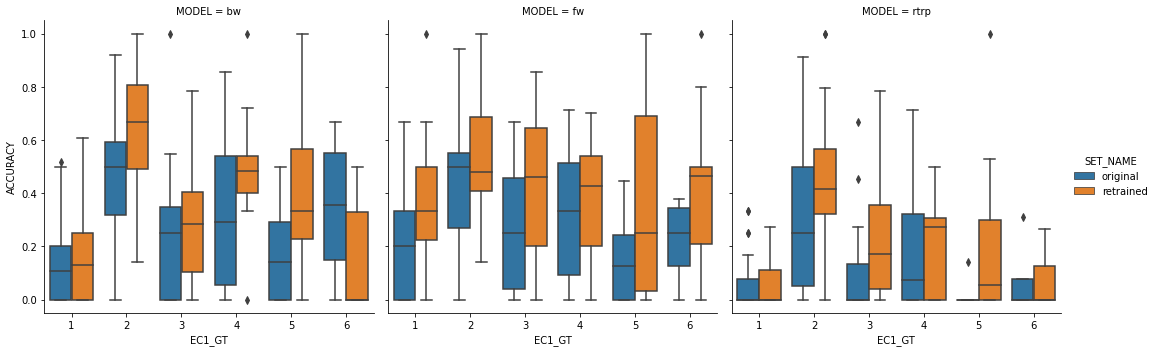

In [146]:
df_sub = df_pivot[(df_pivot["K"] == 1) & (df_pivot["N_TOTAL"] <= 999.0) & (df_pivot["N_TOTAL"] > 1.0)]
sns.catplot(
    data=df_sub, 
    x="EC1_GT", y="ACCURACY", hue="SET_NAME", col="MODEL",
    kind="box"
)

### Performance versus Training Set Size

119


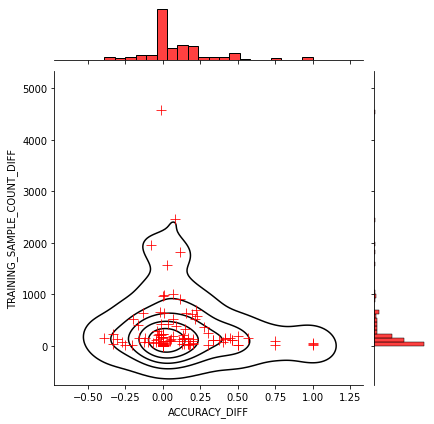

: 

In [216]:
# sns.lmplot(data=df_joined_size[(df_joined_size.K == 1) & (df_joined_size.TRAINING_SAMPLE_COUNT > 500)], x="TRAINING_SAMPLE_COUNT", y="ACCURACY", hue="SET_NAME", col="MODEL")
df_joined_size_subset = df_joined_size[
    (df_joined_size.K == 1) & (df_joined_size.MODEL == "bw") & 
    (df_joined_size.TRAINING_SAMPLE_COUNT_DIFF > 0)
]
print(len(df_joined_size_subset))
g = sns.jointplot(
    data=df_joined_size_subset,
    x="ACCURACY_DIFF", 
    y="TRAINING_SAMPLE_COUNT_DIFF",
    color="r",
    marker="+", s=100
)

g.plot_joint(
    sns.kdeplot, color="k", 
    zorder=0, levels=6)